In [1]:
!pip install tensorflow

In [92]:
import os
import torch 
import numpy as np
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity

In [93]:
from tensorflow.keras.models import Sequential

from keras.models import Model,Sequential, load_model
from keras.layers import LSTM, Input
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

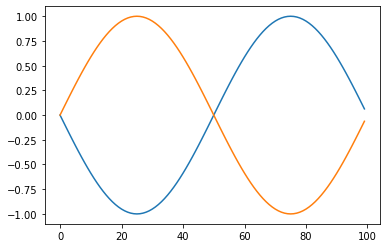

In [94]:
a = np.linspace(-np.pi, np.pi, num=100, endpoint=False)
X = np.sin(a)
Y = np.cos(a - 1.5*np.pi)
plt.plot(range(len(X)),X)
plt.plot(range(len(Y)),Y)
X = X.reshape(100,1,1)
Y = Y.reshape(100,1,1)
#print(X)


In [91]:
dtw(X,Y,4)[-1][-1]

127.03139734796724

In [79]:
# define model
Sine = Sequential()
Sine.add(LSTM(64, activation='relu', input_shape=(1,1), return_sequences=True))
Sine.add(LSTM(10, activation='relu', return_sequences=True))
Sine.add(LSTM(10, activation='relu', return_sequences=True))
Sine.add(LSTM(64, activation='relu', return_sequences=True))
Sine.add(TimeDistributed(Dense(1)))
Sine.compile(optimizer='adam', loss='mse')
#Sine.summary()

# fit model
Sine.fit(X, X, epochs=300, batch_size=1, verbose=0)
# demonstrate reconstruction
yhat = Sine.predict(X, verbose=0)
for i in range(len(yhat)-90):
    print('Predicted---', np.round(yhat[i],3),'---Actual---',np.round(X[i], 3))
    


new_model = Sequential()
new_model.add(Sine.layers[0])
new_model.add(Sine.layers[1])
new_model.summary()

i = 0
for layer in new_model.layers:
    layer.set_weights(Sine.layers[i].get_weights())
    i += 1



Predicted--- [[0.002]] ---Actual--- [[-0.]]
Predicted--- [[0.002]] ---Actual--- [[-0.063]]
Predicted--- [[0.002]] ---Actual--- [[-0.125]]
Predicted--- [[0.002]] ---Actual--- [[-0.187]]
Predicted--- [[0.002]] ---Actual--- [[-0.249]]
Predicted--- [[0.002]] ---Actual--- [[-0.309]]
Predicted--- [[0.002]] ---Actual--- [[-0.368]]
Predicted--- [[0.002]] ---Actual--- [[-0.426]]
Predicted--- [[0.002]] ---Actual--- [[-0.482]]
Predicted--- [[0.002]] ---Actual--- [[-0.536]]
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 1, 64)             16896     
_________________________________________________________________
lstm_55 (LSTM)               (None, 1, 10)             3000      
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________


In [80]:
CoSine = Sequential()
CoSine.add(LSTM(64, activation='relu', input_shape=(1,1), return_sequences=True))
CoSine.add(LSTM(10, activation='relu', return_sequences=True))
CoSine.add(LSTM(10, activation='relu', return_sequences=True))
CoSine.add(LSTM(64, activation='relu', return_sequences=True))
CoSine.add(TimeDistributed(Dense(1)))
CoSine.compile(optimizer='adam', loss='mse')
#CoSine.summary()

CoSine.fit(Y, Y, epochs=300, batch_size=1, verbose=0)
# demonstrate reconstruction
yhat = CoSine.predict(Y, verbose=0)
for i in range(len(yhat)-90):
    print('Predicted---', np.round(yhat[i],3),'---Actual---',np.round(Y[i], 3))
    


new_model2 = Sequential()
new_model2.add(CoSine.layers[0])
new_model2.add(CoSine.layers[1])
new_model2.summary()

i = 0
for layer in new_model2.layers:
    layer.set_weights(model.layers[i].get_weights())
    i += 1

Predicted--- [[-0.001]] ---Actual--- [[0.]]
Predicted--- [[0.061]] ---Actual--- [[0.063]]
Predicted--- [[0.124]] ---Actual--- [[0.125]]
Predicted--- [[0.186]] ---Actual--- [[0.187]]
Predicted--- [[0.249]] ---Actual--- [[0.249]]
Predicted--- [[0.308]] ---Actual--- [[0.309]]
Predicted--- [[0.366]] ---Actual--- [[0.368]]
Predicted--- [[0.424]] ---Actual--- [[0.426]]
Predicted--- [[0.481]] ---Actual--- [[0.482]]
Predicted--- [[0.534]] ---Actual--- [[0.536]]
Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_58 (LSTM)               (None, 1, 64)             16896     
_________________________________________________________________
lstm_59 (LSTM)               (None, 1, 10)             3000      
Total params: 19,896
Trainable params: 19,896
Non-trainable params: 0
_________________________________________________________________


In [81]:
shat = new_model.predict(X[:1], verbose=0)
print(shat)
chat = new_model2.predict(Y[:1], verbose=0)
print(chat)

[[[0.00331686 0.         0.00012646 0.00180636 0.00083846 0.0033508
   0.0021417  0.00098294 0.         0.        ]]]
[[[0.         0.09425826 0.10069322 0.         0.13770501 0.02205095
   0.2539579  0.         0.17063768 0.        ]]]


In [82]:
cosine_similarity(shat[0], chat[0])

array([[0.364194]], dtype=float32)

In [83]:
def dtw(s, t, window):
    n, m = len(s), len(t)
    w = np.max([window, abs(n-m)])
    dtw_matrix = np.zeros((n+1, m+1))
    
    for i in range(n+1):
        for j in range(m+1):
            dtw_matrix[i, j] = np.inf
    dtw_matrix[0, 0] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            dtw_matrix[i, j] = 0
    
    for i in range(1, n+1):
        for j in range(np.max([1, i-w]), np.min([m, i+w])+1):
            cost = abs(s[i-1] - t[j-1])
            # take last min from a square box
            last_min = np.min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
            dtw_matrix[i, j] = cost + last_min
    return dtw_matrix